**<center><font size=5>SETI Breakthrough Listen - E.T. Signal Search 👽</font></center>**
<center><font size=4>By Ben Shaver and Coral Hayoun</font></center>

----
# Abstract

##### **"Are we alone in the Universe?"**

It's one of the most profound human questions.
As technology improves, we're finding new and more powerful ways to seek for answers.

The Breakthrough Listen team at Berkeley University, scans signals from millions of stars in the universe using world's most powerful telescopes, trying
to find some extraterrestial signals - but it is not that easy. By the time, humans have built enormous numbers of radio device that can be detected as signals as well and distract their signals interpetation.

In order to address this issue, they are using two different methods:
1. They intersperses scans of target stars that apprears in more than one regions of the sky - because these scans probably aren't coming from the direction of the target star.
2. They discards signals that don't change their frequency - because it means that they are probably nearby the telescope.

These two methods are quite effective, but they can be improved. The process today misses interesting signals. particularly those with complex time or frequency structure, and those in regions of the spectrum with lots of interference.

<br></br>
In this competition, we will use our machine learning skills to accurately identify the presence of simulated extraterrestial signals in these scans.

Because there are no confirmed examples of alien signals to use to train machine learning algorithms, the team included some simulated signals (that they call “**needles**”) in the haystack of data from the telescopes. They have identified some of the hidden needles so that we can train our model to find more.

<br></br>
<center><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTEZ3m0SFpeTux8e4sV_TLFEqufMkeeBqtl7g&usqp=CAU" width="200"></center>

(from [SETI Breakthrough Listen - Kaggle competition](https://www.kaggle.com/competitions/seti-breakthrough-listen)) <br></br>

----

**Table of Contents**
- <a href='#1'>1. Initial Settings</a>
- <a href='#2'>2. EDA: Exploratory Data Analysis</a>
  - <a href='#2_1'>2.1. Load The Data</a>
  - <a href='#2_2'>2.2. Visualize The Data</a>
  - <a href='#2_3'>2.3. Summery Statistics</a>
- <a href='#3'>3. Data Preprocessing</a>
  - <a href='#3_1'>3.1. Data Augmentation</a>
  - <a href='#3_2'>2.2. Feature Extraction</a>
  - <a href='#3_3'>2.3. Data Splitting</a>

  ----

# <a id='1'>1. Initial Settings</a>

##### 1. Install Libraries

In [ ]:
%pip install setigen

##### 2. Import Libraries

In [2]:
# For operating system and file system
import os
import time
import logging

# For basic functionallity
import math
from enum import Enum

# For data manipulation and analysis
import numpy as np
import pandas as pd

# For Computer Vision Library
import cv2 as cv
from skimage.transform import resize

# For Machine Learning
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA

# For data manipulation
from skimage.transform import resize
#import setigen as stg
from astropy import units as u

# For data visualization
import matplotlib.pyplot as plt
import glob

# For model persistence
import joblib

# Warning filtering
import warnings

In [ ]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

In [ ]:
# Remove unnecessary warning in data aug
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'overflow encountered in reduce')

##### 3. Libraries Version

In [ ]:
print('np version:',np.__version__)
print('pd version:',pd.__version__)
print('tf version:',tf.__version__)
print('sklearn version:',sklearn.__version__)

np version: 1.26.4
pd version: 2.1.4
tf version: 2.16.1
sklearn version: 1.2.2


##### 4. Configuration

In [31]:
class CFG:
    # ------------------------------------#
    # Basic
    # ------------------------------------#
    debug = True
    runOnKaggle = False
    epochs = 6
    train_batch_size = 64
    validation_batch_size = 20
    test_batch_size = 64
    seed = 42
    k_fold = 4

    # ------------------------------------#
    # Paths
    # ------------------------------------#
    base_folder_path = os.path.abspath('../../../Downloads/SETI')
    train_folder_path = f'{base_folder_path}/train'
    test_folder_path = f'{base_folder_path}/test'
    workdir_folder_path = 'working'
    tmp_storage_path = 'tmp'
    logging_file = 'logging.txt'

# ------------------------------------#
# Utils
# ------------------------------------#
def get_data_set_sample(data_set, n, target_ratio):
    positive_values_samples = min(math.floor(n * target_ratio),len(data_set[data_set.target == 1]))
    positive_samples = data_set[data_set.target == 1].sample(n=positive_values_samples, random_state = CFG.seed).reset_index(drop=True)
    complementary_data_set_samples = data_set[data_set.target == 0].sample(n - positive_values_samples, random_state = CFG.seed).reset_index(drop=True)

    return pd.concat([positive_samples, complementary_data_set_samples]).sample(frac = 1).reset_index(drop=True)

# ------------------------------------#
# Datasets
# ------------------------------------#
training_set = pd.read_csv(f'{CFG.base_folder_path}/train_labels.csv')
testing_set = pd.read_csv(f'{CFG.base_folder_path}/sample_submission.csv')

# ------------------------------------#
# On Debug
# ------------------------------------#
if CFG.debug:
    CFG.epochs = 1
    CFG.train_batch_size = 50
    CFG.validation_batch_size = 25
    CFG.test_batch_size = 50
    
    CFG.test_folder_path = CFG.train_folder_path
    training_set = get_data_set_sample(training_set, 2000, 0.3)
    testing_set = get_data_set_sample(training_set, 2000, 0.3)

    training_set.to_csv('train_debug.csv', index=False)
    testing_set.to_csv('test_debug.csv', index=False)

# ------------------------------------#
# On Kaggle Running
# ------------------------------------#
if CFG.runOnKaggle:
    CFG.tmp_storage_path = '/kaggle/tmp'

##### 5. Utils Methods

In [47]:
def get_batched_data (data, batch_size, index):
  return data[index * batch_size : (index + 1) * batch_size]

def plot_cadence_snippet(cadence_snippet):
    figure = plt.figure(figsize=(8, 5))
    for i in range(6):
        plt.subplot(6, 1, i + 1)
        plt.imshow(cadence_snippet[i].astype('float16'), aspect='auto')
    figure.text(0.5, 0.04, 'Frequency', ha='center', fontsize=8)
    figure.text(0.04, 0.5, 'Time', va='center', rotation='vertical', fontsize=8)
    plt.show()

def plot_merged_cadence_snippet(file, title):
    plt.figure(figsize=(8, 5))
    plt.title(title) 
    plt.imshow(file, aspect='auto')

def write_predictions_to_file(prediction_data, testing_set_labels, file_name):
  results = testing_set_labels.assign(target=prediction_data)
  selected_column = ['id', 'target']
  final_results = results[selected_column]
  final_results.to_csv(file_name, index=False)

def get_batch_number(index, batch_size):
  return math.floor(index / batch_size)

def get_index_in_batch(index, batch_size):
  return index - (get_batch_number(index, batch_size) * batch_size)

def log(message, shouldPrint=False):
   if shouldPrint:
    print(message)
   logging.info(message)

def save_model(model, name):
    joblib.dump(model, f'{CFG.workdir_folder_path}/{name}.pkl')
  
def load_model(name):
  return joblib.load(f'{CFG.workdir_folder_path}/{name}.pkl')

def get_duration(start_time):
   return (time.time() - start_time) / 60

##### 6. Initial Methods

In [33]:
# Create tmp Directory
if not os.path.exists(CFG.tmp_storage_path):
    os.makedirs(CFG.tmp_storage_path)

# Create working Directory
if not os.path.exists(CFG.workdir_folder_path):
    os.makedirs(CFG.workdir_folder_path)
    
# Create logging file
if not os.path.exists(CFG.logging_file):
    with open(CFG.logging_file, 'w'):
        pass

# Setup logger
logging.basicConfig(
    level=logging.INFO,  
    format='%(asctime)s - %(message)s',  
    filename=CFG.logging_file,  
    filemode='a'  
  )

----

# <a id='2'>2. EDA: Exploratory Data Analysis </a>


With our libraries and configurations set up, we begin the exploratory data analysis or EDA.

The **goal of EDA** is to understand the data underlying structure and patterns, identify important variables, detect outliers and anomalies and formulate hypotheses for further investigation. 

This process will involve several steps including data loading, visualizations and some data statistics.


### <a id='2_1'>2.1. Data Loading</a>

Even though our task sounds like a *signal* detection problem, we are actually solving an *image* classification problem.

The data we are provided with is radio spectrograms - a visual representation of the spectrum frequencies of a signal as it varies with time. <br></br>


Our dataset actually contains:
- a `train_labels.csv` file, which has our labels indicating the presence of an alien signal (referred to as needles) for each of the spectograms
- `train` folder contains `.npy` float16 files with the spectrograms stored as arrays
- Similarly, `test` folder also contains `.npy` float16 files with the test spectrograms stored as arrays
- Of course, we are provided with a `test_labels.csv` file! <br></br>

Now, let's check our `train` data:

In [34]:
def get_file_path(image_id, folder_path):
  return '{}/{}/{}.npy'.format(folder_path, image_id[0], image_id)

training_set['file_path'] = training_set['id'].apply(lambda id: get_file_path(image_id=id, folder_path=CFG.train_folder_path))
testing_set['file_path'] = testing_set['id'].apply(lambda id: get_file_path(image_id=id, folder_path=CFG.test_folder_path))

# Create test_labels.csv
testing_files = testing_set['file_path']
testing_set.assign(file=testing_files).to_csv('test_labels.csv', index=False)
testing_set_labels = pd.read_csv('test_labels.csv')
testing_set_labels['predicted_label'] = 0

training_set.head()

,id,target,file_path
0,35fac088e1b4ff9,0,c:\Users\koral\Downloads\SETI/train/3/35fac088...
1,a0e9140a3562d25,0,c:\Users\koral\Downloads\SETI/train/a/a0e9140a...
2,aa2450d0f749491,0,c:\Users\koral\Downloads\SETI/train/a/aa2450d0...
3,246565a3a64e004,0,c:\Users\koral\Downloads\SETI/train/2/246565a3...
4,235ef421b2fdadd,0,c:\Users\koral\Downloads\SETI/train/2/235ef421...


### <a id='2_2'>2.2. Visualize The Data</a>

Every training set example is called **cadence snippet**, which looks like this:

My shape is: (6, 273, 256)


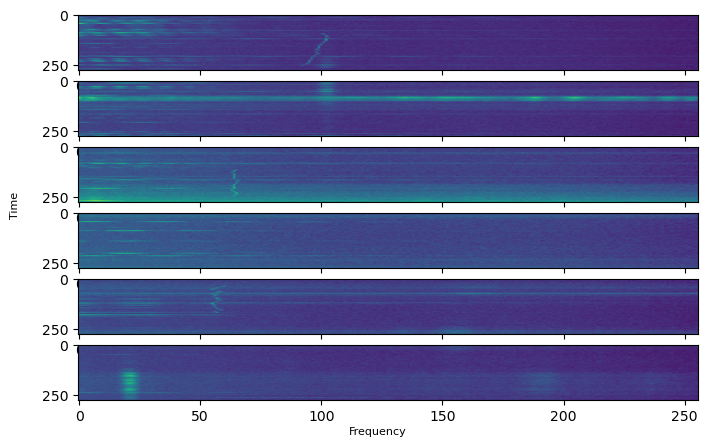

In [6]:
cadence_snippet = np.load(get_file_path('00776881dd80050', CFG.train_folder_path))
print(f'My shape is: {cadence_snippet.shape}')
plot_cadence_snippet(cadence_snippet)

Now, let's break this **cadence snippet** down:

**Firstly**, the individual plots signify a **cadence**, and the combination of the 6 plots is called a **cadence snippet**

**Secondly**, as we can see, the spectrogram has a shape of `(6, 273, 256)` - which stands for a represantation of 6 spectrograms in 2D.
The reason for the 6 spectrograms, as we already mentioned in the Abstract section, is that in order to deal with human-generated signals (like radion stations or wifi routers), Breakthrough Listen team are looking for **signals that appear to be coming from particular positions on the sky**.

Typically they do this by alternating observations of a primary target star with observations of three nearby stars:
- 5 minutes on star “A”
- then 5 minutes on star “B”
- then back to star “A” for 5 minutes
- then “C”
- then back to “A”
- then finishing with 5 minutes on star “D”.

One set of six observations (ABACAD) is referred to as our *cadence snippet*.

**Third**, The curves we see in the signal's lines, are because the relative motion of the Earth and the spacecraft imparts a Doppler drift, causing the frequency to change over time. 


<br></br>Now, let's watch some more cadence snippets:

Here is a non-alien signals example:


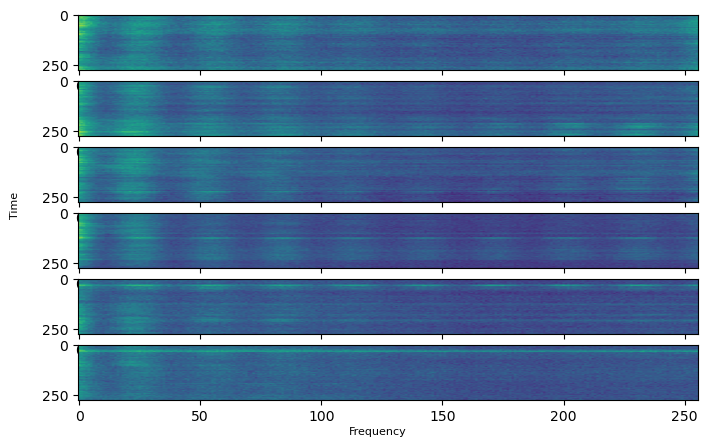


Here is an easy alien signals example:


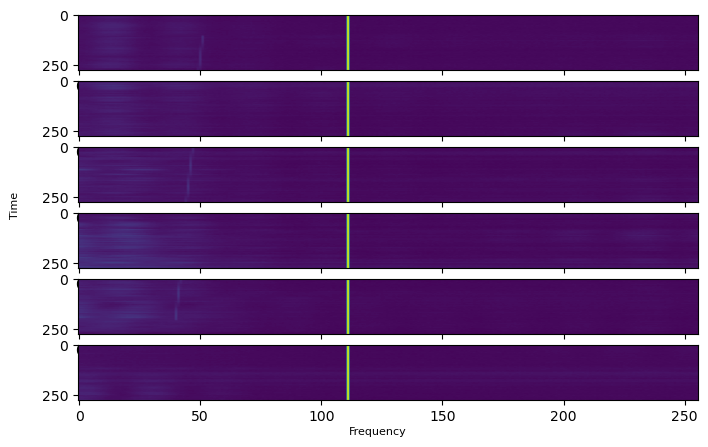


Here is a hard alien signals example:


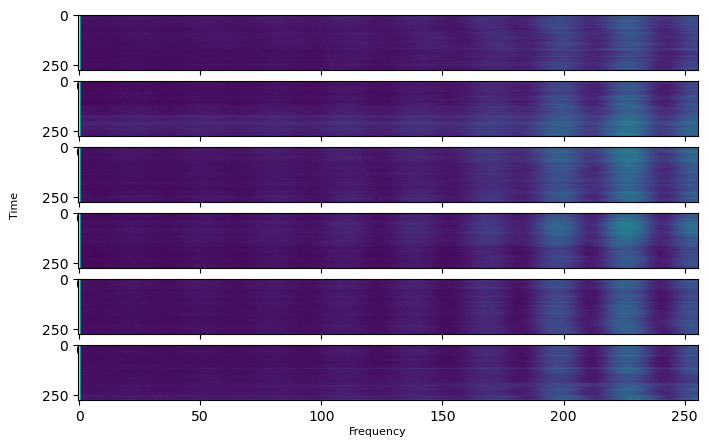

In [37]:
print('Here is a non-alien signals example:')
plot_cadence_snippet(np.load(get_file_path('0000799a2b2c42d', CFG.train_folder_path)))

print('\nHere is an easy alien signals example:')
plot_cadence_snippet(np.load(get_file_path('d618b77bb0909c2', CFG.train_folder_path)))

print('\nHere is a hard alien signals example:')
plot_cadence_snippet(np.load(get_file_path('fffbb1c9c3d6c31', CFG.train_folder_path)))

As we can see, some of these needles should be easy to detect, but others are hidden in noisy regions of the spectrum and will be harder - we will try to handle it in the next section. <br></br>


2.3 Statistics
Add blockquote

Let's create a histogram of the label frequencies in order to understand how rare is having a "needle" occurance:

There are 6000 'needles', which is 10.0 % of the training set. 



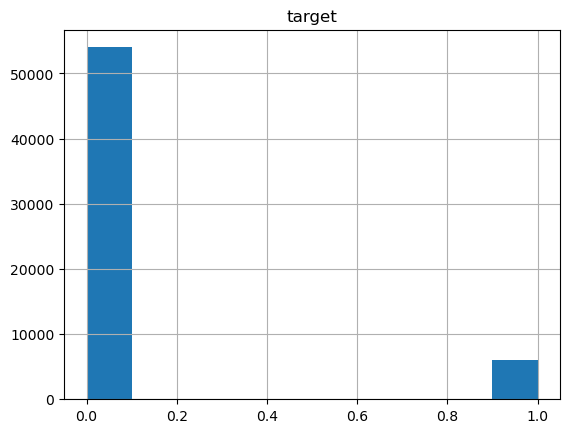

In [ ]:
training_set.hist()

needles = len(training_set[training_set.target==1])

print(f"There are {needles} 'needles', which is {(needles / len(training_set) * 100)} % of the training set. \n")

Looks like our dataset is very imbalanced - We will handle this as well in the next sections. <br></br>

----

# <a id='3'>3. Data Preprocessing</a>

There are few things we can do to make the data more effiecient for our needs:

1. **Data Cleaning** - we can remove noises from the data and keep only the relevant features of the data.
2. **Data Augmentation** - we can apply data augmentation techniques to increase the diversity of the training dataset, like - rotation, flipping, scaling, or adding noise to the spectrograms.
3. **Data Adjustments** - we can make some adjustemnts like merge all the spectrogram into one image, normalize it, etc
4. **Data Splitting** - we need to split our train dataset into `training` and `validation` datasets in order to evaluate the performance of our model effectively and improve it, using K-fold cross-validation.


### <a id='3_1'>3.1. Data Cleaning - Fourier Transform</a>

As we can see in the data visualizations - the horizontal lines are mostly noise and can be eliminated (the vertical or inclined lines are the ones that relevant for us)

For filtering out horizontal lines, we can use `Fourier Transform`, but first - we need to understand its meaning


>In the picture below, we can see the **Time Domain** representation of a audio signal, which shows the "loudness" (amplitude) of sounds wave changing with time. To better understand a audio signal, it is necessary to transform it into the **Frequency Domain** representation. This representation of a signal tells us what different frequencies are present in the signal.<br></br>
  <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*e-_z80BnbHWyFTfRLblJ_w.gif" width="400"> <br></br>
> **Fourier Transform** is a mathematical concept that can *decompose a signal into its constituent frequencies*. In its 2D plot output, the x-axis represent the signal frequencies and the y-axis represent their magnitudes (amplitude size). There is also **Inverse Fourier Transform** concept, which is just the opposite of the Fourier Transform.<br></br>
 For a better understanding of Fourier Transform output - let's create two simple sine waves, with two different frequencies:  *amplitude = 1 and frequency = 3* and *amplitude = 2 and frequency = 11*.
 Now, we can combine them into a single signal, that will look like that - <br></br>
  <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*WBldOpArJgDXIFs5g_JydA.png" width="400"> <br></br>
> The output of Fourier Transform will show two spikes  for the two frequencies and their magnitues <br></br>
  <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*aIyR6XoUYGJp0_3Ug6iEyA.png" width="400"> <br></br>
for more information  [understand autio fft](https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520)


<br></br>
Having said that, we can use *Fourier Transform* to mask the spectrogram's horizontal lines - they are represented as vertical lines in the central area of the fourier image:

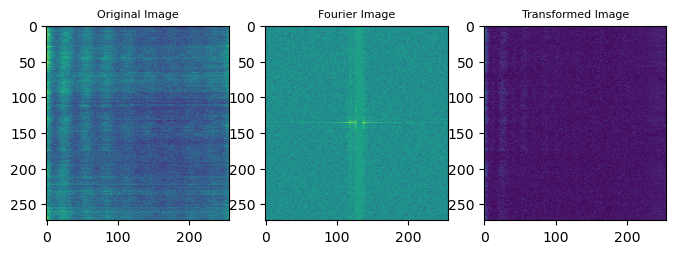

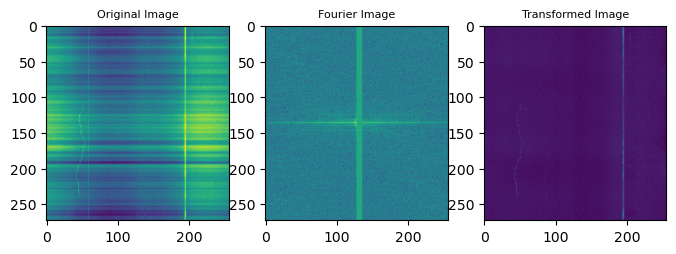

In [35]:
def fourier_vertical_lines_mask(spectrogram):
    spectrogram_frequencies_domain = np.fft.fft2(spectrogram)
    # Shitf the zero-frequency to the center of the image, making it more intuitively
    spectrogram_frequencies_domain = np.fft.fftshift(spectrogram_frequencies_domain)
    # Mask the central area of the fourier image (probably a horizontal line)
    spectrogram_frequencies_domain[:, 128:136] = 1

    return spectrogram_frequencies_domain

def plot_fourier_transform_preprocess(spectrogram, frequencies_domain):
    _ , columns = plt.subplots(1,3,figsize=(8,8))

    # Original Image
    columns[0].imshow(spectrogram)
    columns[0].set_title('Original Image', fontsize = 8)
    # Fourier Transformation Image
    columns[1].imshow(np.log(abs(frequencies_domain)))
    columns[1].set_title('Fourier Image', fontsize = 8)
    # Transformed Image using Inverse Fourier Transformation
    columns[2].imshow(abs(np.fft.ifft2(frequencies_domain)))
    columns[2].set_title('Transformed Image', fontsize = 8)

# Main
spectrograms = [((np.load(f'{CFG.base_folder_path}/example.npy').astype('float16'))/255)[0], 
                ((np.load(f'{CFG.base_folder_path}/positive.npy').astype('float16'))/255)[0]
]

for spectrogram in spectrograms:
  frequencies_domain = fourier_vertical_lines_mask(spectrogram)
  plot_fourier_transform_preprocess(spectrogram, frequencies_domain)

After undestanding the Fourier masking concept, we can write the full preprocess function for our future preprocess pipeline:

In [36]:
def fourier_transform_preprocess(spectrograms):
  masked_spectrograms = []
  for spectrogram in spectrograms:
    spectrogram = spectrogram.astype('float16')/255
    masked_spectrogram = fourier_vertical_lines_mask(spectrogram)
    masked_spectrogram = np.abs(np.fft.ifft2(masked_spectrogram))
    # Float16 type casting is important here! np.abs return its answer in float64 format, which makes our training data 4 times bigger
    masked_spectrograms.append(masked_spectrogram.astype(np.float16))

  return masked_spectrograms

### <a id='3_2'>3.2. Data Augmentation </a>

As we have discussed before the amount of positive data we have is very limited and therefore we decided we have to do some data augmentation.
Data augmentation could be implemented in multiple ways,
either by taking some example from our data and applying to it transformations for example rotation, translation, adding noise and so on or by generating new data.
Generating new data is a bit more trickier as to so we have to be familiar with the data we are searching so the model will be trained on relevant data.

After some digging we have encountered a library named `setigen` which can help us with the data augementation as it can generate by itself filterbank's that demoonstrate real one, and there are abilities of adding noise or signals of different forms.

For more details,
read:
https://github.com/bbrzycki/setigen/blob/main/README.md  
or  
https://setigen.readthedocs.io/en/main/index.html


In [ ]:
from astropy import units as u
from astropy.time import Time
from pathlib import Path
import scipy

import setigen as stg


In [ ]:
def create_cadence():
    cadence = stg.Cadence()
    cadence_numpy_array = []

    # Decide strategy, one of two:
    # Negative sample - take a negative sample and add a signal to convert it to a positive signal
    # Positive sample - take a positive sample and add noise to it
    strategy = np.random.choice(['positive', 'positive'])
    sample = random_base_sample(strategy)

    # Create 6 instances of Frame to construct a Cadence
    for i in range(6):
        frame = stg.Frame(data=sample[i])
        cadence.append(frame)
    
    cadence = strategy_change(strategy, cadence)

    for frame in cadence:
        cadence_numpy_array.append(frame.get_data())
    
    return np.array(cadence_numpy_array)

def random_base_sample(strategy):
    target = 0 if strategy == 'negative' else 1
    sample_filepath = training_set[training_set.target == target].sample(n = 1).reset_index(drop=True).iloc[0]['file_path']
    sample_data = np.load(sample_filepath).astype('float16')
    return sample_data

def strategy_change(strategy, cadence):
    if strategy == 'negative':
        return negative_strategy_change(cadence)
    elif strategy == 'positive':
        return positive_strategy_change(cadence)
    
def positive_strategy_change(cadence):\n",
    """
    Add random rfi to a positive sample to add more diversity
    """
    start_signal_at_frequency = np.random.randint(0, cadence[0].fchans)
    constant_intensity_profile = np.random.randint(1, 10)
    signal_width = np.random.randint(1, 10)

    cadence.add_signal(stg.constant_path(f_start=cadence[0].fs[start_signal_at_frequency],
                                       drift_rate=0*u.Hz/u.s),
                 stg.constant_t_profile(level=constant_intensity_profile),
                 stg.box_f_profile(width=signal_width*u.Hz),
                 stg.constant_bp_profile(level=1))

    return cadence

def negative_strategy_change(cadence):\n",
    """
    Add random signal to a negative sample.
    In that way we convert negative samples to a positive ones
    and use them for the dataaugmentation.
    """
    start_signal_at_frequency = np.random.randint(0, cadence[0].fchans/4)
    constant_intensity_profile = np.random.randint(1, 10)
    signal_width = np.random.randint(1, 10)

    for frame in cadence:
        frame.add_signal(stg.constant_path(f_start=frame.fs[start_signal_at_frequency],
                                           drift_rate=-0.01*u.Hz/u.s),
                     stg.constant_t_profile(level=constant_intensity_profile),
                     stg.box_f_profile(width=signal_width*u.Hz),
                     stg.constant_bp_profile(level=1))
    return cadence


We can check out our result by plotting an example of a cadence snippen created from the data augmentation process: 

In [ ]:
plot_cadence_snippet(create_cadence())

The data augmentation should be integrated as simply as possible, so we could behave to it is it is part of the given train data.

In [ ]:
def data_aug(samples):
    data_aug_df = pd.DataFrame(columns=['id', 'target', 'file_path'])
    for i in range(samples):
        file_path = f'{CFG.tmp_storage_path}/{i}'
        sample = create_cadence()
        np.save(file_path, np.asarray(sample, dtype=np.float16))
        data_aug_df.loc[i] = [i, 1, file_path]
    return data_aug_df

### <a id='3_3'>3.3. Data Adjustments </a>

Our training set files contains .npy array of 6 spectrograms, lets merge them into one and normalize it:

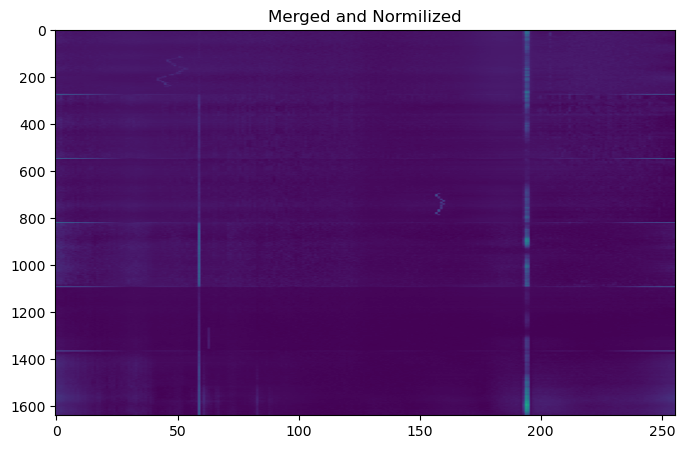

In [37]:
def merge_spectrograms_preprocess(npy_file):
    return np.vstack(npy_file)

def normalize_spectrograms_preprocess(npy_file):
    mean_value = np.mean(npy_file)
    std_value = np.std(npy_file)
    return (npy_file - mean_value) / std_value
    
# Main
example_file = np.load(f'{CFG.base_folder_path}/positive.npy')

example_file = fourier_transform_preprocess((example_file))
example_file = merge_spectrograms_preprocess(example_file)
example_file = normalize_spectrograms_preprocess(example_file)

plot_merged_cadence_snippet(example_file, 'Merged and Normilized')

After all of this preprocessing functions, we can create our official preprocessing pipeline:

In [38]:
def preprocessing_pipeline(data_set):
  processed_data_set = []

  for data_file_path in data_set['file_path']:
    data = (np.load(data_file_path))

    # Mask horizontal lines
    processed_data = fourier_transform_preprocess(data)

    # Merge all spectrograms into one image
    processed_data = merge_spectrograms_preprocess(processed_data)

    # Normalized the spectrograms values
    processed_data = normalize_spectrograms_preprocess(processed_data)
    
    processed_data_set.append(processed_data.flatten())

  return processed_data_set

When we first tried to run this pipeline - we did it on the whole training set and saved it results in our memory, which caused our application to crash.
Then, we understood that we used a very unefficient way for preprocessing the data, so we fixed it:
- First, we needed to store the processed data in a place that is not our RAM - so, we chose to do it with our file system
- Secondly,we decided to run this process in batching with time.sleep between them

Let's see the code atfer our few teaks:

In [39]:
def preprocessing_batched_pipeline(data_set, batch_size, preprocessing_callback, data_set_name): 
  for i in range(0, len(data_set), batch_size):
    batched_preprocessed_data_set = []
    batched_data_set = data_set[i : i + batch_size]
    batch_numbar = int(i / CFG.train_batch_size)

    log(f'Started preprocess {data_set_name} data set batch number {batch_numbar}')
    batched_preprocessed_data_set = preprocessing_callback(batched_data_set)

    storing_path = f'{CFG.tmp_storage_path}/batched_{data_set_name}_set_data_{batch_numbar}.npy'
    np.save(storing_path, np.asarray(batched_preprocessed_data_set, dtype=np.float16))
    log(f'Finised preprocess {data_set_name} data set batch number {batch_numbar}')
    time.sleep(5)

Now we can invoke this pipeline on our data sets (train and test): 
> luckily - we can do it only once, instead of running it in every single training (like we did, in the beginning):

In [40]:
preprocessing_batched_pipeline(training_set, CFG.train_batch_size, preprocessing_pipeline, "train")
preprocessing_batched_pipeline(testing_set, CFG.train_batch_size, preprocessing_pipeline, "test")

### <a id='3_4'>3.4. Data Splitting </a>

In `K-fold cross-validation`, the original dataset is divided into K subsets (folds) of approximately equal size.
Our model will train K times, each time using K-1 folds as the training data and the remaining fold as the validation data.

This technique helps to provide a more reliable estimate of the model's performance compared to a single train-test split, as it uses multiple validation sets and reduces the variance in the performance estimate.

Now, lets do it:

In [13]:
k_fold_splitter = StratifiedKFold(n_splits=CFG.k_fold, shuffle=True, random_state=CFG.seed)
splitted_training_set = k_fold_splitter.split(training_set, training_set['target'])

for fold_index, (train_index, validation_index) in enumerate(splitted_training_set):
    training_set.loc[validation_index, 'fold'] = int(fold_index)
    training_set['fold'] = training_set['fold'].fillna(-1).astype(int)
    
display(training_set.groupby(['fold', 'target']).size())

c:\Users\koral\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


fold  target
0     0         7
      1         1
1     0         7
      1         1
2     0         7
3     0         7
dtype: int64

----

# <a id='4'>4. Building A Model</a>

### <a id='4_1'>4.1 A Simple Model</a>

We have decided to start with some simple machine learning model, to understand its accuracy:
* Logistic Regression
* SVM
* Perceptron 

The common thing among all of those models is that they are all supervised learning algorithms for a binary classfication task (just for a reminder, our goal is to predict either 0 or 1)

After submitting the results of all of the models we will compare between them.

For all 3 machine learning models, we will use the `sklearn.linear_model.SGDClassifier` class as it allows on-line learning with the `partial_fit` method.

##### #Logistic Regression
We will start with the `Logistic Regression`,  
In the `Logistic Regression` the relationship between the input features and the probability of the binary outcome is modeled using the logistic function the sigmoid function.  
  
<img src="https://helloacm.com/wp-content/uploads/2016/03/logistic-regression-example.jpg" width="300">
<br></br>


In [42]:
model = SGDClassifier(loss='log_loss')
#model = load_model('Logistic Regression')

After defining the model, we wrote our whole training process function:

In [48]:
train_data_path_prefix = f'{CFG.tmp_storage_path}/batched_train_set_data_'

def batched_training(model, x_train, y_train):
  for i in range(0, len(x_train)):
    if i % CFG.train_batch_size == 0:
        time.sleep(10)

    log(f'Started training batch {i}')    
    data_path = f'{train_data_path_prefix}{x_train[i][0]}.npy'
    x_train_batch = [np.load(data_path)[x_train[i][1]]]
    y_train_batch = [y_train[i]]
    model.partial_fit(x_train_batch, y_train_batch, classes=np.unique(training_set['target']))
    log(f'Finised training batch {i}') 

def batched_validation(model, x_validation, y_validation):
  batches_num = 0
  total_score = 0
  x_validation_batch = []
  y_validation_batch = []

  for i in range(0, len(x_validation), CFG.validation_batch_size):
      time.sleep(5)
      log(f'Started validation batch {int(i / CFG.validation_batch_size)}')    
      for j in range(CFG.validation_batch_size):
        if i + j >= len(x_validation):
          break

        data_path = f'{train_data_path_prefix}{x_validation[i+j][0]}.npy'
        x_validation_batch.append(np.load(data_path)[x_validation[i+j][1]])
        y_validation_batch.append(y_validation[i+j])

      score = model.score(x_validation_batch, y_validation_batch)
      x_validation_batch = []
      y_validation_batch = []
      total_score += score
      batches_num += 1
      log(f'Finished validation batch {int(i / CFG.validation_batch_size)}')
  return total_score / batches_num

def model_training_process(model):
  fold_scores = []
  start_time = time.time()

  splitted_training_set = k_fold_splitter.split(training_set, training_set['target'])

  for fold_index, (train_index, validation_index) in enumerate(splitted_training_set):
    x_train = []
    y_train = []
    x_validation = []
    y_validation = []
    for i in train_index: 
        x_train.append((get_batch_number(i, CFG.train_batch_size), get_index_in_batch(i, CFG.train_batch_size)))
        y_train.append(training_set['target'][i])

    for i in validation_index:  
        x_validation.append((get_batch_number(i, CFG.train_batch_size), get_index_in_batch(i, CFG.train_batch_size)))
        y_validation.append(training_set['target'][i])

    # Train the model
    log(f'Started training {fold_index} fold at {get_duration(start_time)} min', True)
    batched_training(model, x_train, y_train)
    log(f'Finished training {fold_index} fold at {get_duration(start_time)} min. {CFG.k_fold - fold_index - 1} remaines', True)

    # Evaluate the model
    log(f'Started validation {fold_index} fold at {get_duration(start_time)} min', True)
    fold_score = batched_validation(model, x_validation, y_validation)
    fold_scores.append(fold_score)
    log(f'Finished validation {fold_index} fold at {get_duration(start_time)} min. its score is {fold_score}', True)

  log(f'Finished trainning by {get_duration(start_time)} min. the validation scores for each fold are:{fold_scores}', True)

The code we see here, is the final code we used for training this model, but it had a lot of teaks and changes for making it effiecient enough for running without crashing our application:
- First, our `x_train` and `y_train` variables, used to keep all the training set data - so we changed it for keeping only its batching metadata
- Secondly, although our training used `partial_fit` for batching implementation, our validation part did not implemented batching, so we needed to do it as well.
<br></br>

Now, after finishing the training process, we can work on the predicting part:

In [49]:
test_data_path_prefix = f'{CFG.tmp_storage_path}/batched_test_set_data_'

def batched_predictions(model):
  prediction_batch = []

  for i in range(0, len(testing_set_labels), CFG.test_batch_size):
      batch_numbar = int(i / CFG.test_batch_size)
      data_path = f'{test_data_path_prefix}{batch_numbar}.npy'

      for j in range(CFG.test_batch_size):
        if i + j >= len(testing_set_labels):
          break
        

        prediction_batch.append(np.load(data_path)[j])

      score = model.predict(prediction_batch)

      for j in range(CFG.test_batch_size):
        if i + j >= len(testing_set_labels):
          break
      
        target_id = testing_set_labels.iloc[i + j]['id']
        testing_set_labels.loc[testing_set_labels['id'] == target_id, 'predicted_label'] = score[j] 
      
      prediction_batch = []

def calc_precision_and_recall():
  true_positives = 0
  false_positive = 0
  false_negative = 0

  predictions = testing_set_labels['predicted_label']
  true_labels = testing_set_labels['target'] == 1

  true_positives += np.sum(np.logical_and(predictions == 1, true_labels == 1))
  false_positive += np.sum(np.logical_and(predictions == 1, true_labels == 0))
  false_negative += np.sum(np.logical_and(predictions == 0, true_labels == 1))
  
  # Precision - "Out of all the cases predicted as positive, how many were actually positive?"
  precision = true_positives / (true_positives + false_positive) if (true_positives + false_positive) > 0 else 0
  # Recall - "Out of all the actual positive cases, how many did the model correctly identify?"
  recall = true_positives / (true_positives + false_negative) if (true_positives + false_negative) > 0 else 0

  return {'precision': precision, 'recall': recall}

Now, all thats left is to combine all this parts together:
- We start with processed train and test datasets, stored in our file system in batches
- Then, we can use our batched model training and validation
- And then, all thats left is to predict the test set values and to check the model accuracy.

In [50]:
def run_learning_process(model, model_name):
    # Train the model
    model_training_process(model)
    save_model(model, model_name)

    # Predict test values
    batched_predictions(model)
    testing_set_labels.to_csv(f'test_labels_{model_name}.csv', index=False)
    results = calc_precision_and_recall()
    
    print(f'The model precision is: {results['precision']} and recall: {results['recall']}')

run_learning_process(model, 'Logistic Reg')

Started training 0 fold at 0.052999019622802734 sec
Finished training 0 fold at 334.4733655452728 sec. 3 remaines
Started validation 0 fold at 334.4733655452728 sec
Finished validation 0 fold at 443.64120173454285 sec. its score is 0.8240000000000002
Started training 1 fold at 443.69120144844055 sec
Finished training 1 fold at 775.3768930435181 sec. 2 remaines
Started validation 1 fold at 775.3778955936432 sec
Finished validation 1 fold at 884.2500972747803 sec. its score is 0.8740000000000002
Started training 2 fold at 884.300096988678 sec
Finished training 2 fold at 1218.181547164917 sec. 1 remaines
Started validation 2 fold at 1218.181547164917 sec
Finished validation 2 fold at 1327.223605632782 sec. its score is 0.9120000000000001
Started training 3 fold at 1327.273607492447 sec
Finished training 3 fold at 1659.8873722553253 sec. 0 remaines
Started validation 3 fold at 1659.8883736133575 sec
Finished validation 3 fold at 1769.0460107326508 sec. its score is 0.9080000000000001
Finis

##### #Perceptron

Now we will look into the `perceptron` which is one of the simplest forms of artificial neural networks,    
The `perceptron` consists of one or more input nodes, a weight associated with each input, an activation function, a weighted sum function, and a single output node.  
Each input node represents a feature of the input data, and each weight represents the importance of its corresponding feature.  
The output node produces a binary output (0 or 1), representing the predicted class.  
  
The weighted sum of the inputs is calculated and then it goes through an activation function which then returns the output.
  
<img src="https://miro.medium.com/v2/resize:fit:1400/1*gGmqkjA0VJCe5EhJnoQDNg.png" width="500">
<br></br>

In [ ]:
model = SGDClassifier(loss='perceptron')

##### #SVM

The purpose of SVM is simmilar to the `perceptron` which is to find hyperplane for binary classification.

  
<img src="https://baeldung.com/wp-content/uploads/sites/4/2021/03/svm-all.png" width="300" backgroupcolor="white">
<br></br>

In [ ]:
model = SGDClassifier(loss='hinge')

##### # Issues we found
After running the simple models, We realized we have two major problems we need to solve:
- The accuracy of the results are pretty bad
- This process is really time consuming and exhausting


**First**, we handled the duration issue, because it was our worst problem - we understood that our dataset examples are too big, and we needed  to reduce it:
The major thing we realized, is that looking only on the target star's spectrograms can be pretty helpful. The thing all the needles have in common is that they all present in some or all of the target star's spectrograms, so we should first reduce the data to contain only these spectrograms and then check if this data is enough for prediction or maybe just a good primary strainer.

My shape is: (819, 256)


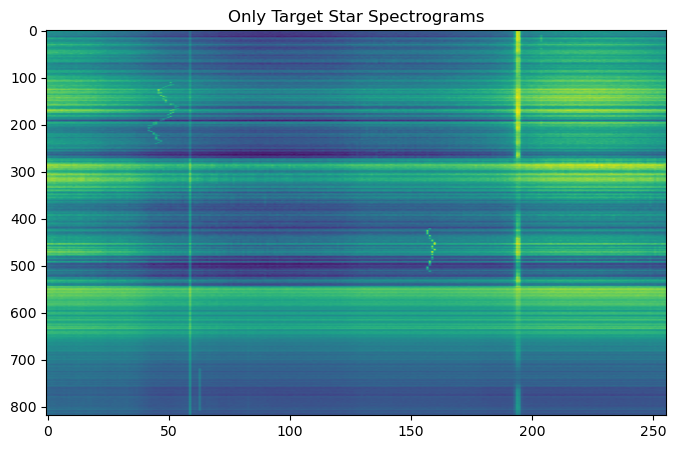

In [20]:
def merge_target_star_spectrograms_preprocess(npy_file):
    return np.vstack([npy_file[0], npy_file[2], npy_file[4]])

cadence_snippet = np.load(f'{CFG.base_folder_path}/positive.npy')
cadence_snippet = merge_target_star_spectrograms_preprocess(cadence_snippet)

print(f'My shape is: {cadence_snippet.shape}')
plot_merged_cadence_snippet(cadence_snippet, 'Only Target Star Spectrograms')

Then, we did a resize, trying to make the image even smaller:

My shape is: (409, 128)


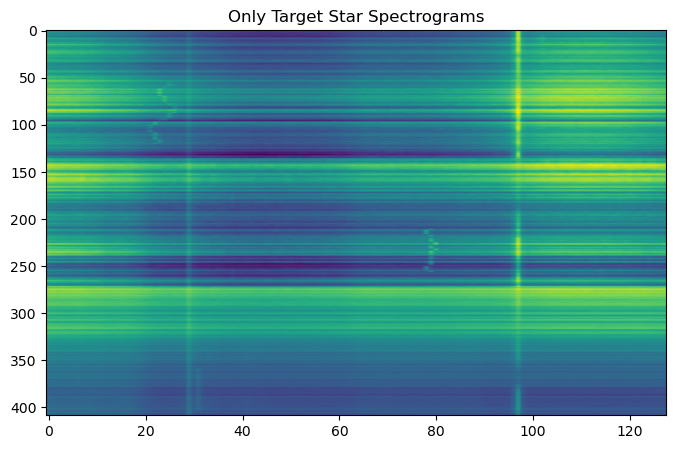

In [25]:
def resize_spectrograms_preprocess(cadence_snippet):
    new_shape = (cadence_snippet.shape[0] // 2, cadence_snippet.shape[1] // 2)
    return resize(cadence_snippet, new_shape)

resized_cadence_snippet = resize_spectrograms_preprocess(cadence_snippet)
print(f'My shape is: {resized_cadence_snippet.shape}')
plot_merged_cadence_snippet(resized_cadence_snippet, 'Only Target Star Spectrograms')

After that, we tried some more things that didnt worked for us - dimensionality reduction and feature extraction
- The first thing we did was **dimensionality reduction**, but it turned out that its distorting the image quality (although we tried 3 different ways: PCA, TSNE and UMAP)
- The second thing was **feature extraction**, which turned out that its not pretty helpful in reducing image size (although we tried 3 different ways: SIFT, HOG and LBP). it may be helpful for the model in other ways, by making it easier for him to find the meaningful spots in the image - but we chose to change to model to deep learning one so it wont be needed anyway. <br></br>

Here some of the code we tried:

c:\Users\koral\anaconda3\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


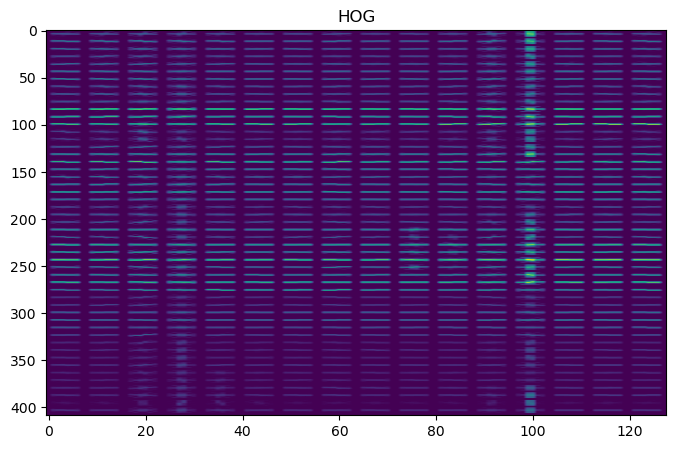

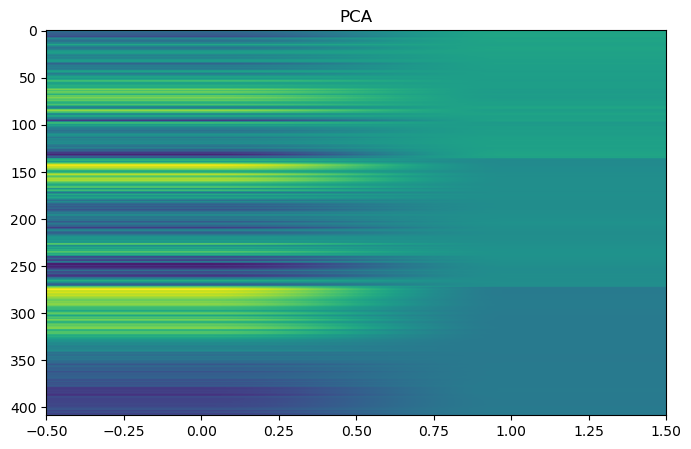

In [24]:
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn.manifold import TSNE

# Feature Extraction
hog_features, hog_image = hog(resized_cadence_snippet, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
plot_merged_cadence_snippet(hog_image, 'HOG')

radius = 4
n_points = 8 * radius
lbp_image = local_binary_pattern(resized_cadence_snippet, n_points, radius, method='uniform')

# Dimensionality Reduction
pca = PCA(n_components=2)
pca_array = pca.fit_transform(resized_cadence_snippet)
plot_merged_cadence_snippet(pca_array, 'PCA')

tsne = TSNE(n_components=3)  
tsne_array = tsne.fit_transform(resized_cadence_snippet)

Now, we can combine it all into new preprocess pipeline function, so we can pass it as a parameter to our `batched_preprocess_pipeline`:

In [26]:
def better_preprocessing_pipeline(data_set):
  processed_data_set = []

  for data_file_path in data_set['file_path']:
    data = (np.load(data_file_path))

    # Mask horizontal lines
    processed_data = fourier_transform_preprocess(data)

    # Merge all spectrograms into one image
    processed_data = merge_target_star_spectrograms_preprocess(processed_data)

    # Normalized the spectrograms values
    processed_data = normalize_spectrograms_preprocess(processed_data)
    
    # Resize the spectrogram shape
    processed_data = resize_spectrograms_preprocess(processed_data)
    
    processed_data_set.append(processed_data.flatten())

  return processed_data_set

The **second** problem we should have solve, was the model accuracy issue. We used at first the most simple models we can find, with all the default parameters - which is probably not good enough to our model. So, we did two things:
- We moved to **deep learning model**, who should help us get better results
- We used **data augmantation**,to simulate more needles because of the fact our data is very imbalanced.

### <a id='5_2'>5.2 A Deep Learning Model</a>
We will use Keras to build our model.

In Keras, `Sequence` is a class provided by the `keras.utils` module. It's commonly used for creating custom data generators for efficiently load and preprocess data in batches during training.

For more information [tf.keras.utils.Sequnece](https://www.tensorflow.org/api_docs/python/tf/keras/utils/PyDataset)


In [ ]:
# data: the dataset that the data generator will iterate over
# labels: the labels associated with the input data
# batch_size: the number of samples to include in each batch
# shuffle: A boolean value indicating whether to shuffle the data at the beginning of each epoch
# preprocessing_function: Optional argument for specifing a function for data preprocessing

class SETISequence(Sequence):
    def __init__(self, data, labels, batch_size, shuffle):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

    # Returns the total number of batches in the dataset
    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    # Returns a batch of data at a given index
    def __getitem__(self, index):
        data_ids_batch = get_batched_data(self.data, self.batch_size, index)
        labels_batch = get_batched_data(self.labels, self.batch_size, index)
        data_list = []

        for id in data_ids_batch:
          data = np.load(get_train_file_path(id))
          data = data.astype('float')/255
          data = fourier_transform_preprocess(data)
          data_list.append(data)

        data_batch = np.moveaxis(data_list, 1, -1)

        return data_batch, labels_batch

# Main
#train = (pd.read_csv('data/train_labels.csv'))
#train = train[train['id'].isin(['000cd479c2106d4', '000e869ed875e40', '00a1d9ce5045cd5', '00a1fbc9e9986d6', '00a3b4346d21596'])]
#batch_size = 1 #32
#dataset = SETISequence(train['id'], train['target'], batch_size, True)
#dataset.__getitem__(3)

Now, we can initiate our Keras model. 
For this - we need to define our model architecture first.
> *Model Architecture* - refers to the overall structure of our neural network.  It defines how the various 
layers are organized and connected to form a computational graph that transforms input data into output predictions.
Model Architecture is builds from:
>1. Input Layer - where the input data is fed into the network
>2. Hidden Layers - the intermediate layers between the input and output layers where the actual computation takes place.
>3. Output Layer - where the network produces its output predictions
>4. Model Depth and Width - The depth of a neural network refers to the number of hidden layers it contains, 
while the width refers to the number of neurons in each layer.

Now, we can take a look on our model layers:
- We start with Convolutional layer - the building blocks of CNNs and are used to extract features from input images.
The `Conv2D` layer using set of learnable filters (also known as kernels) to produce feature maps. In our code, the `Conv2D` layer has 3 filters with a 
kernel size of (3,3) and uses the ReLU activation function.
- Then, we can use EfficientNetB2 architecture - a pretrained convolutional neural network (CNN) model, that initialized
with weights pretrained on the ImageNet dataset.
- The next layer is used to reduce the spatial dimensionality of the image extracted features before passing them to the fully connected layers
- The next two layers would be Dense layers - which using ReLu activation function in order to capture complex patterns in the data.
- And the last one - the output layer has a single neuron with sigmoid activation that produces a binary classification output (0 or 1)

In [ ]:
# EfficientNetB2 must have 3 channels so we need to pre-proceess the data for it
model = tf.keras.Sequential([
        Conv2D(3,(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(273,256,6)),
        EfficientNetB2(input_shape=(273, 256, 6), weights='imagenet', include_top=False, drop_connect_rate=0.4),
        GlobalAveragePooling2D(), 
        Dense(128, activation='relu'), 
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
])

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 16s 1us/step
